In [1]:
#!/usr/bin/env python

# Generative Adversarial Networks (GAN) example in PyTorch.
# See related blog post at https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [22]:
# Data params
data_mean = 4
data_stddev = 1.25

# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 1   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = d_input_size

d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999) #  ?
num_epochs = 30000
print_interval = 200
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

In [19]:
# ### Uncomment only one of these
(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

print("Using data [%s]" % (name))

Using data [Raw data]


In [3]:
# ##### DATA: Target data and generator input data

def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

### The real data distribution

(array([   1.,    1.,    3.,    6.,    7.,   23.,   37.,   71.,   85.,
         103.,  120.,  145.,  113.,   95.,   82.,   51.,   31.,   15.,
           9.,    2.]),
 array([-0.6223197 , -0.21207006,  0.19817958,  0.60842922,  1.01867886,
         1.42892849,  1.83917813,  2.24942777,  2.65967741,  3.06992705,
         3.48017669,  3.89042633,  4.30067596,  4.7109256 ,  5.12117524,
         5.53142488,  5.94167452,  6.35192416,  6.7621738 ,  7.17242343,
         7.58267307]),
 <a list of 20 Patch objects>)

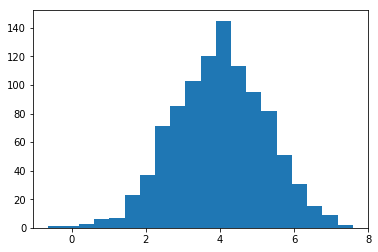

In [4]:
data_sampler = get_distribution_sampler(4, 1.25)
plt.hist(data_sampler(1000).numpy()[0], bins=20)

In [52]:
ddd = Variable(torch.Tensor(data_sampler(50).t()))
y_ = Variable(torch.Tensor(np.zeros((50,1))))
fifty_by_two = torch.cat([ddd,y_],1) #torch.FloatTensor of size 50x2

### The gen <span style="color:red">noise</span>  distribution

(array([ 46.,  49.,  38.,  41.,  49.,  50.,  55.,  59.,  40.,  45.,  62.,
         40.,  48.,  53.,  58.,  65.,  57.,  54.,  45.,  46.]),
 array([  5.34415245e-04,   5.04927635e-02,   1.00451112e-01,
          1.50409460e-01,   2.00367808e-01,   2.50326157e-01,
          3.00284505e-01,   3.50242853e-01,   4.00201201e-01,
          4.50159550e-01,   5.00117898e-01,   5.50076246e-01,
          6.00034595e-01,   6.49992943e-01,   6.99951291e-01,
          7.49909639e-01,   7.99867988e-01,   8.49826336e-01,
          8.99784684e-01,   9.49743032e-01,   9.99701381e-01]),
 <a list of 20 Patch objects>)

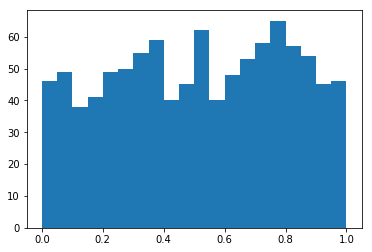

In [5]:
gen_sampler = get_generator_input_sampler()
plt.hist(gen_sampler(1000,1).numpy(),bins=20)

In [17]:
# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))

In [6]:
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)

# understanding the above 3 fns, esp. decorate_with_diffs()

In [18]:
print (extract(Variable(torch.FloatTensor([[1, 2, 3], [4, 5, 6]]))))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]


In [19]:
print (stats([[1, 2, 3], [4, 5, 6]]))

[3.5, 1.707825127659933]


In [7]:
a = Variable(torch.randn(4, 2))
a

Variable containing:
-1.0997  0.6125
 1.5411 -0.4024
 1.3758 -1.5379
-0.1244  0.5653
[torch.FloatTensor of size 4x2]

In [8]:
mean = torch.mean(a.data, 1, keepdim=True)
mean


-0.2436
 0.5693
-0.0810
 0.2204
[torch.FloatTensor of size 4x1]

In [9]:
mean_broadcast = torch.mul(torch.ones(a.size()), mean.tolist()[0][0])
mean_broadcast


-0.2436 -0.2436
-0.2436 -0.2436
-0.2436 -0.2436
-0.2436 -0.2436
[torch.FloatTensor of size 4x2]

In [10]:
exponent = 1
diffs = torch.pow(a - Variable(mean_broadcast), exponent)
diffs

Variable containing:
-0.8561  0.8561
 1.7846 -0.1588
 1.6193 -1.2943
 0.1192  0.8089
[torch.FloatTensor of size 4x2]

In [13]:
torch.cat([a, diffs], 1)

Variable containing:
-1.0997  0.6125 -0.8561  0.8561
 1.5411 -0.4024  1.7846 -0.1588
 1.3758 -1.5379  1.6193 -1.2943
-0.1244  0.5653  0.1192  0.8089
[torch.FloatTensor of size 4x4]

In [34]:
d_sampler = get_distribution_sampler(data_mean, data_stddev)
gi_sampler = get_generator_input_sampler()
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

In [20]:
print ('minibatch_size =',minibatch_size, '')

minibatch_size = 1 


In [115]:
G_mean = [0] * (num_epochs)
G_std = [0] * (num_epochs)

In [126]:
for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        d_real_data = Variable(d_sampler(d_input_size)) 
        d_real_decision = D(preprocess(d_real_data))
        d_real_error = criterion(d_real_decision, Variable(torch.ones(1)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(preprocess(d_fake_data.t()))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)))  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        g_fake_data = G(gen_input)
        dg_fake_decision = D(preprocess(g_fake_data.t()))
        g_error = criterion(dg_fake_decision, Variable(torch.ones(1)))  # we want to fool, so pretend it's all genuine

        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters
        
    G_mean [epoch] = stats(extract(d_fake_data))[0]
    G_std[epoch] = stats(extract(d_fake_data))[1]
    
    if epoch % print_interval == 0:
        print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                            extract(d_real_error)[0],
                                                            extract(d_fake_error)[0],
                                                            extract(g_error)[0],
                                                            stats(extract(d_real_data)),
                                                            stats(extract(d_fake_data))))
        

### the mean and std of fake data converge to the true distribution over iter ! :)

Text(0.5,1,'mean on fake')

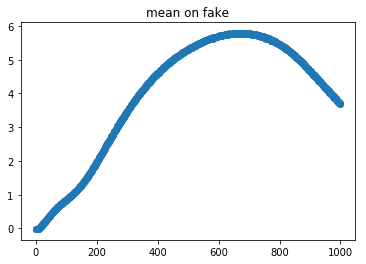

In [185]:
plt.scatter(range(1000),G_mean[:1000])
plt.title('mean on fake')

Text(0.5,1,'std on fake')

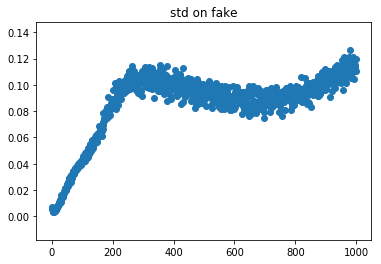

In [184]:
plt.scatter(range(1000),G_std[:1000])
plt.title('std on fake')

In [134]:
d_gen_input = Variable(gi_sampler(100, g_input_size))
d_fake_data = G(d_gen_input).detach()  #
np.std(d_fake_data.t().data.numpy()[0])

1.121775

## a minibatch comparison between real and fake data after GAN trainining

(array([  8.,   3.,   4.,   4.,   8.,   8.,  10.,  11.,  11.,  33.]),
 array([ 1.21355176,  1.63902409,  2.06449642,  2.48996875,  2.91544108,
         3.34091341,  3.76638575,  4.19185808,  4.61733041,  5.04280274,
         5.46827507]),
 <a list of 10 Patch objects>)

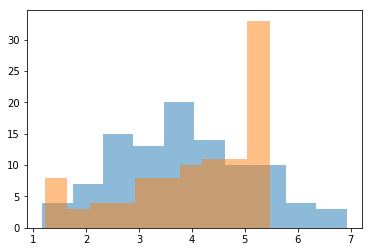

In [106]:
d_real_data = Variable(d_sampler(d_input_size)) 
d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
d_fake_data = G(d_gen_input).detach() 
plt.hist(d_real_data.data.numpy()[0], alpha=0.5, label='real')
plt.hist(d_fake_data.t().data.numpy()[0],alpha=0.5, label='fake')


## Let's now try GAN on a data distribution with 2 modes:

In [54]:
G_mean = [0] * (num_epochs)
G_std = [0] * (num_epochs)
# Data params
data_mean1 = 4
data_mean2 = 10
data_stddev = 1.25

# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 100   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 1   # Minibatch size - cardinality of distributions
d_hidden_size = 100   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = d_input_size

d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999) #  ?
num_epochs = 5000
print_interval = 200
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

In [55]:
d_sampler1 = get_distribution_sampler(data_mean1, data_stddev)
d_sampler2 = get_distribution_sampler(data_mean2, data_stddev)
gi_sampler = get_generator_input_sampler()
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

In [199]:
for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        d_real_data = Variable(torch.cat((d_sampler1(d_input_size//2),d_sampler2(d_input_size//2)),dim=1)) 
        d_real_decision = D(preprocess(d_real_data))
        d_real_error = criterion(d_real_decision, Variable(torch.ones(1)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(preprocess(d_fake_data.t()))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)))  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        g_fake_data = G(gen_input)
        dg_fake_decision = D(preprocess(g_fake_data.t()))
        g_error = criterion(dg_fake_decision, Variable(torch.ones(1)))  # we want to fool, so pretend it's all genuine
        #g_error = - criterion(dg_fake_decision, Variable(torch.zeros(1)))  # the minimax loss fn

        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters
        
    G_mean [epoch] = stats(extract(d_fake_data))[0]
    G_std[epoch] = stats(extract(d_fake_data))[1]
    
    if epoch % print_interval == 0:
        print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                            extract(d_real_error)[0],
                                                            extract(d_fake_error)[0],
                                                            extract(g_error)[0],
                                                            stats(extract(d_real_data)),
                                                            stats(extract(d_fake_data))))
        

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0: D: 1.233513593673706/0.6410353779792786 G: 0.7371582388877869 (Real: [6.9746486365795137, 3.3026643517246956], Fake: [0.3740467891097069, 0.00064067660253644626]) 
200: D: 0.0021541654132306576/0.6415621042251587 G: 0.8124486804008484 (Real: [7.1001580476760866, 3.3232368223264341], Fake: [0.87012571334838862, 0.011072296537847049]) 
400: D: 0.01674630679190159/0.08369474112987518 G: 2.5970120429992676 (Real: [7.0475778847932817, 3.2858861800528212], Fake: [0.91639260709285741, 0.0093857501352422809]) 
600: D: 0.0016902657225728035/0.03659990429878235 G: 3.330387830734253 (Real: [6.8253358232975003, 3.0859955442678864], Fake: [0.43343013763427735, 0.0096613257732387995]) 
800: D: 0.0023223881144076586/0.06422552466392517 G: 2.741546154022217 (Real: [7.1804334998130797, 3.247174340154853], Fake: [-0.097972439602017403, 0.032593808562840464]) 
1000: D: 1.6689438780304044e-05/0.020730216056108475 G: 3.883105993270874 (Real: [7.0895178225636482, 3.3646766302084288], Fake: [-0.0174495231

### bi-modal real distribution gives GAN a <span style="color:red">bad</span> fit

(array([ 220.,  126.,  105.,   68.,   58.,   60.,   69.,   92.,   85.,  117.]),
 array([-2.32009768, -1.76593652, -1.21177535, -0.65761418, -0.10345302,
         0.45070815,  1.00486932,  1.55903049,  2.11319165,  2.66735282,
         3.22151399]),
 <a list of 10 Patch objects>)

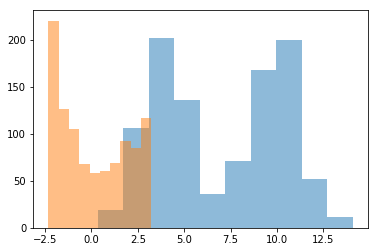

In [200]:
d_real_data = Variable(torch.cat((d_sampler1(1000//2),d_sampler2(1000//2)),dim=1)) 
d_gen_input = Variable(gi_sampler(1000, g_input_size))
d_fake_data = G(d_gen_input).detach() 
plt.hist(d_real_data.data.numpy()[0], alpha=0.5, label='real')
plt.hist(d_fake_data.t().data.numpy()[0],alpha=0.5, label='fake')


### mean of GAN fake data:
### with G trying to maximize D thinking fake are true

Text(0.5,1,'mean on fake')

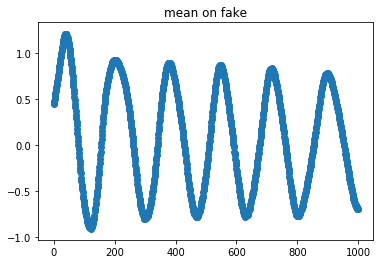

In [189]:
plt.scatter(range(1000),G_mean[:1000])
plt.title('mean on fake')

### mean of GAN fake data:
### with G trying to minimize D thinking fake are fake

Text(0.5,1,'mean on fake')

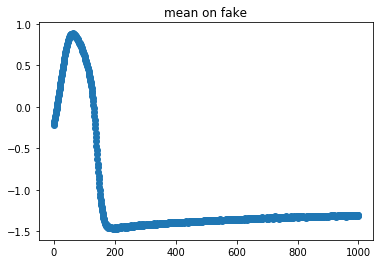

In [196]:
plt.scatter(range(1000),G_mean[:1000])
plt.title('mean on fake')

## Next we try conditional GAN, where we add dimensions of the class labels to both z and x

### key difference is we add  <span style="color:red">batch_size</span> and  <span style="color:red">classes</span>

In [208]:
# Data params
data_mean1 = 4
data_mean2 = 8
data_stddev = 2
classes = 2

# Model params
noise_dim = 1   #new
g_input_size = noise_dim + classes    # Random noise dimension coming into generator, per output vector
g_hidden_size = 100   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 1 + classes
d_hidden_size = 100   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = d_input_size

d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999) #  ?
num_epochs = 5000
print_interval = 200
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1
batch_size = 100

In [209]:
d_sampler1 = get_distribution_sampler(data_mean1, data_stddev)
d_sampler2 = get_distribution_sampler(data_mean2, data_stddev)
gi_sampler = get_generator_input_sampler()
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

In [210]:
# d_real_data = Variable(torch.cat((d_sampler1(batch_size//2),d_sampler2(batch_size//2)),dim=1).t())
# y = torch.Tensor(np.zeros((batch_size,2)))
# y[0:50, 0] = 1
# y[50:100,1] = 1
# y = Variable(y)
# d_real_data = torch.cat((d_real_data,y),dim = 1)
# d_real_decision = D(preprocess(d_real_data))
# d_real_decision

In [211]:
# d_gen_input = Variable(gi_sampler(batch_size, noise_dim))
# d_gen_input = torch.cat((d_gen_input,y),dim = 1)
# # plt.hist(G(d_gen_input).data.numpy())
# d_fake_data = G(d_gen_input).detach()
# extract(d_fake_data)[:batch_size//2]

In [212]:
G_mean1 = [0] * (num_epochs)
G_std1 = [0] * (num_epochs)
G_mean2 = [0] * (num_epochs)
G_std2 = [0] * (num_epochs)

In [213]:
for epoch in range(num_epochs):
    for d_index in range(d_steps):
        
        #the labels 
        y = torch.Tensor(np.zeros((batch_size,2)))
        y[0:50, 0] = 1 #one-hot encoding
        y[50:100,1] = 1
        y = Variable(y)
        
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        d_real_data = Variable(torch.cat((d_sampler1(batch_size//2),d_sampler2(batch_size//2)),dim=1).t())
        d_real_data = torch.cat((d_real_data,y),dim = 1)
        d_real_decision = D(preprocess(d_real_data))
        d_real_error = criterion(d_real_decision, Variable(torch.ones(batch_size)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params
        
        #  1B: Train D on fake
        d_gen_input = Variable(gi_sampler(batch_size, noise_dim))
        d_gen_input = torch.cat((d_gen_input,y),1)
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        d_cond_fake_data = torch.cat((d_fake_data, y), dim=1)  #add the labels again
        d_fake_decision = D(preprocess(d_cond_fake_data))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(batch_size)))  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(batch_size, noise_dim))
        gen_input = torch.cat((gen_input, y),1)  #one-hot key encoding                 
        g_fake_data = G(gen_input)
        cond_fake_data = torch.cat((g_fake_data, y), dim=1) #one-hot
        dg_fake_decision = D(preprocess(cond_fake_data))
        g_error = criterion(dg_fake_decision, Variable(torch.ones(batch_size)))  # we want to fool, so pretend it's all genuine
        #g_error = - criterion(dg_fake_decision, Variable(torch.zeros(1)))  # the minimax loss fn, doesnt' work in practice

        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters
        
    G_mean1 [epoch] = stats(extract(d_fake_data)[:batch_size//2])[0]  #d_fake_data is batch_size x 1
    G_std1 [epoch] = stats(extract(d_fake_data)[:batch_size//2])[1]
    G_mean2 [epoch] = stats(extract(d_fake_data)[batch_size//2:])[0]
    G_std2 [epoch] = stats(extract(d_fake_data)[batch_size//2:])[1]
    
    if epoch % print_interval == 0:
        print("%s: D_error: %s/%s G_error: %s (Fake1_stat: %s, Fake2_stat: %s) " % (epoch,
                                                            extract(d_real_error)[0],
                                                            extract(d_fake_error)[0],
                                                            extract(g_error)[0],
                                                            stats(extract(d_fake_data)[:batch_size//2]),
                                                            stats(extract(d_fake_data)[batch_size//2:])) )

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0: D_error: 0.8002294898033142/0.7161825299263 G_error: 0.6697580814361572 (Fake1_stat: [0.16668700873851777, 0.0011120469825129768], Fake2_stat: [0.19176239728927613, 0.00070676252686206439]) 
200: D_error: 0.7818872928619385/0.5641982555389404 G_error: 0.937325119972229 (Fake1_stat: [5.3016502666473393, 0.10303544930718292], Fake2_stat: [5.1332050228118895, 0.11628638262243593]) 
400: D_error: 0.6281898617744446/0.5575540065765381 G_error: 0.8526409864425659 (Fake1_stat: [7.3534895801544193, 0.095251387461274734], Fake2_stat: [7.2951818180084231, 0.1186646987991932]) 
600: D_error: 0.5500155091285706/0.4885380268096924 G_error: 0.9699310064315796 (Fake1_stat: [5.578627977371216, 0.18911677227061158], Fake2_stat: [6.1102145957946776, 0.1088540387476722]) 
800: D_error: 0.8367720246315002/1.1189606189727783 G_error: 0.43791821599006653 (Fake1_stat: [0.32812181062996387, 0.18629147244303532], Fake2_stat: [7.1391159248352052, 0.13005636862543807]) 
1000: D_error: 0.9325944781303406/0.647

### use class conditional GAN helps the Generator to differentiate between 2 classes
### this can be clearly seen in the mean of 2 groups of fake data over iterations
### initially the 2 groups of fake data have same mean, but then they <span style="color:red">diverge!</span>

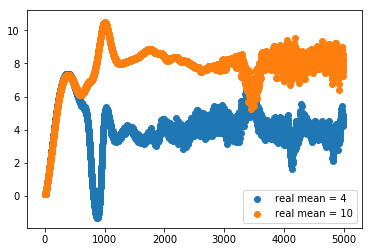

In [215]:
plt.scatter(range(num_epochs),G_mean1, label = 'real mean = 4')
plt.scatter(range(num_epochs),G_mean2, label = 'real mean = 10')
plt.legend()

### real vs fake data

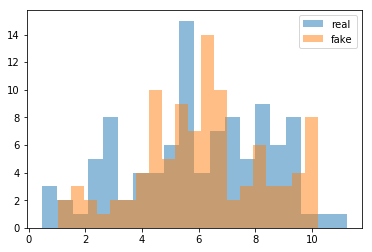

In [235]:
d_real_data = Variable(torch.cat((d_sampler1(batch_size//2),d_sampler2(batch_size//2)),dim=1).t())
d_gen_input = Variable(gi_sampler(batch_size, noise_dim))
d_gen_input = torch.cat((d_gen_input,y),1)
d_fake_data = G(d_gen_input).detach() 
plt.hist(d_real_data.t().data.numpy()[0], alpha=0.5, label='real',bins=20)
plt.hist(d_fake_data.t().data.numpy()[0],alpha=0.5, label='fake',bins=20)
plt.legend()


### generator tends to only generate data at the modes...

In [217]:
d_fake_data.t().data.numpy()

array([[  6.53956461,   3.12827229,   3.47013307,   2.48666763,
          5.46774292,   2.01648593,   2.09684825,   6.84108543,
          2.55475831,   5.25800562,   2.10198569,   6.5283227 ,
          3.92599893,   3.83765244,   2.18179178,   2.78112292,
          2.34228802,   3.79891825,   6.68838882,   1.64929903,
          6.80301285,   3.99558783,   4.20680714,   0.99752003,
          4.63154697,   4.26748753,   1.98585463,   2.97410727,
          2.99522328,   4.53212643,   5.42330742,   6.21435833,
          5.09812355,   4.19124889,   4.46619797,   3.83016253,
          2.83361602,   2.47617316,   6.71303082,   3.39060116,
          2.84204626,   2.22345638,   5.43011284,   1.12441516,
          6.39122152,   3.45335722,   1.69607317,   1.20689869,
          2.91798949,   3.05504036,   6.41871881,   3.99173284,
          5.20423269,   6.69814587,   7.95310259,   7.8901782 ,
          8.4844141 ,   4.26375866,   9.19951916,   7.99129009,
          8.66865444,   7.12755489,   7.